In [ ]:
# f = (f' - B - d * t) / med (f' - b - d * t)
# D = D' - B
# B = B' + Berr

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

In [ ]:
# # parameters
# # gain electrons per adu
# g = 3.6
# # dimension 
# row = 2048
# column = 2048
# # bias levels 
# # real bias level count per pixel 
# bias_real_level = 300
# # the systematic readout error on the bias
# readnoise = 5
# # assumed bias level 
# # float up to factor 
# factor = 2 
# bias_meas_array = np.linspace(bias_real_level/factor, bias_real_level*factor)
# # bias_meas_array = [bias_real_level]
# # dark
# # dark current elec per sec
# d = 0.05
# # time dark exposure
# td = 60
# # flat counts per pixel 
# f = 10000
# # time flat exposure 
# tf_array = np.linspace(3, 120)

In [ ]:
# para_dict = {
#     'bias_level': 300,
#     'row': 2048,
#     'column': 2048,
#     'g': 3.6,
#     'readnoise': 5,
#     'd': 0.05,
#     'td': 60,
#     'f': 10000,
#     'tf_array': np.linspace(3, 120)   
# }

In [ ]:
# function making a bias based on a given bias input
# normal distributed 
# output: 2d bias level in counts per pixel 
# def makeBias(bias_level,size=(row,column),readnoise=5,debug=False):
#     bias = np.random.normal(bias_level, readnoise, size)
#     return bias

In [ ]:
# def makeDarkCounts(td=60,d=0.05,size=(row,column),debug=False,g=3.6):
#     dark_counts = np.random.poisson(d*td, size) / g 
#     return dark_counts

In [ ]:
# # dark function based on a given bias input
# # possion distributed
# # output: 2d dark current in counts per sec per pixel 
# def makeDark(bias_level,td=60,d=0.05,size=(row,column),debug=False,g=3.6):
#     dark = makeDarkCounts(td=td,d=d,size=size,debug=debug,g=g) + \
#                               makeBias(bias_level,size=size,debug=debug)
#     return dark    

In [ ]:
# # flat function 
# # possion distributed 
# # output: 2d raw flat level in counts per pixel 
# def makeRawFlat(bias_level,debug=False,g=3.6,
#                 f=15000,size=(row,column)):
#     flat = makeBias(bias_level) + np.random.poisson(f, size)
#     return flat

In [ ]:
# # calibrated flat function 
# # output: 2d calibrated flat level in counts per pixel 
# def makeCaliFlat(bias, dark, raw_flat, tf=3, td=60, debug = False):
#     caliFlat = (raw_flat - dark / td * tf - bias) / np.median(raw_flat - dark / td * tf - bias)
#     return caliFlat 

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def generate_custom_gaussian_circle(resolution, center_value, sigma, edge_value):
#     center_x, center_y = resolution / 2, resolution / 2
#     grid = np.zeros((resolution, resolution))
    
#     for x in range(resolution):
#         for y in range(resolution):
#             distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
#             # Calculate the Gaussian-like value with a custom mean
#             value = (np.random.normal(300, 5) + np.random.poisson(center_value)) * np.exp(-0.5 * (distance / sigma)**2) 
            
#             # Clamp values to be within [edge_value, center_value]
#             # value = max(edge_value, min(center_value, value))
            
#             # Assign the value to the grid
#             grid[x, y] = value
    
#     return grid

# resolution = 2048
# center_value = 15000  # Adjust this value for the center peak
# edge_value = 0   # Adjust this value for the edge
# sigma = 4000          # Adjust this value to control the spread of values

# custom_gaussian_circle = generate_custom_gaussian_circle(resolution, center_value, sigma, edge_value)
# display(np.mean(custom_gaussian_circle))

# plt.imshow(custom_gaussian_circle, cmap='viridis')
# plt.colorbar()
# plt.show()



In [ ]:
# def systematic_deviation(bias_level, time = 1, tf_array = tf_array, debug = False):
#     # see the error with same bias 
#     percent_change_in_flat_array = []
#     percent_change_in_flat_array_std = []
#     tf_plot_array = []
#     for tf in tf_array:
#         percent_change_in_flat_array_storage = []
#         for i in range(time):
#             bias_real_1 = makeBias(bias_level)
#             dark_real_1 = makeDark(bias_level)
#             flat_raw_1 = makeRawFlat(bias_level, tf)
#             flat_real_1 = makeCaliFlat(bias_real_1, dark_real_1, flat_raw_1, tf)
#             bias_real = makeBias(bias_level)
#             dark_real = makeDark(bias_level)
#             flat_raw = makeRawFlat(bias_level, tf)
#             flat_real = makeCaliFlat(bias_real, dark_real, flat_raw, tf)
#             deltaf = np.abs(flat_real - flat_real_1)
#             # flat percent change in a mean form 
#             percent_change_in_flat = np.mean(deltaf / flat_real_1 * 100)
#             percent_change_in_flat_array_storage.append(percent_change_in_flat)
#         mean = np.mean(percent_change_in_flat_array_storage)
#         std = np.std(percent_change_in_flat_array_storage)
#         percent_change_in_flat_array.append(mean)
#         percent_change_in_flat_array_std.append(std)
#         tf_plot_array.append(tf)
#     plt.scatter(tf_plot_array, percent_change_in_flat_array)
#     plt.errorbar(tf_plot_array, percent_change_in_flat_array,
#                 yerr = percent_change_in_flat_array_std,
#                 fmt ='o')
#     plt.xlabel('TF changes')
#     plt.ylabel('Flat changes perc')
#     plt.show()
    

In [61]:
#----------------------------------------------------------------------
# Overall concept
#----------------------------------------------------------------------

# f = (f' - B - d * t) / med (f' - b - d * t)
# D = D' - B
# B = B' + Berr
#

#----------------------------------------------------------------------

# modelues using versions on bellerophon
import numpy as np
import matplotlib.pyplot as plt
# from quick_image import *
from scipy.optimize import curve_fit

#----------------------------------------------------------------------

# default parameters
# ccd dimension (pixels)
row = 2048
column = 2048
# gain of the camera (electron per adu)
g = 0.95
# bias levels 
# real bias level (count per pixel)
bias_real_level = 300
# assumed bias level 
# float up to factor 
factor = 2 
bias_meas_array = np.linspace(bias_real_level/factor, bias_real_level*factor)
# bias read out noise (counts per pixel)
readnoise = 15
# dark 
# dark current (electrons per second per pixel)
d = 0.05
# dark exposure time (sec)
td = 60
# flat 
# flat (counts per pixel)
f = 15000
# time flat exposure (sec)
tf_array = np.linspace(3, 120)


#----------------------------------------------------------------------
# bias, dark, and flat simulation frame


#----------------------------------------------------------------------
# function making a bias based on a given bias input 
# default para
# size, readnoise, and debug util
# input, bias_level (counts per pixel)
# bias level normally distributed 
# output: 2d bias level in counts per pixel
def makeBias(bias_level,size=(row,column),readnoise=readnoise,debug=False):
    bias = np.random.normal(bias_level, readnoise, size)
    if debug:
        display_image(bias,siglo=0.5,sighi=0.5,fignum=1)
        plt.colorbar()
    return bias

#----------------------------------------------------------------------
# fucntion making the raw dark counts 
# default para
# size, debug until, gain (g), time for dark exposure (td), and dark current (d)
# possion distributed
# output: 2d dark current in counts per pixel 
def makeDarkCounts(td=td,d=d,size=(row,column),debug=False,g=g):
    dark_counts = np.random.poisson(d*td, size) / g 
    if debug:
        display_image(dark_counts,siglo=0.5,sighi=0.5,fignum=2)
        plt.colorbar()
    return dark_counts

# function making the dark counts with the bias level based on a given bias input 
# default para
# time for dark exposure (td), dark curent (d), size, debug until, gain (g)
# input bias level (counts per pixel)
# calls the makeDarkCountrs function 
# output 2d true dark current in counts per pixel 
def makeDark(bias_level,td=td,d=d,size=(row,column),debug=False,g=g):
    dark = makeDarkCounts(td=td,d=d,size=size,debug=debug,g=g) + makeBias(bias_level,size=size,debug=debug)
    if debug:
        display_image(dark,siglo=0.5,sighi=0.5,fignum=3)
        plt.colorbar()
    return dark     


#----------------------------------------------------------------------
# function making the flat frame counts given a bias level input 
# default para
# flat counts (f), debug util, gain (g), size 
# input, bias level (counts per pixel)
# possion distributed 
# output: 2d raw flat level in counts per pixel 
def makeRawFlat(bias_level,debug=False,g=g,
                f=f,size=(row,column)):
    flat = makeBias(bias_level) + np.random.poisson(f, size)
    if debug:
        display_image(flat,siglo=0.5,sighi=0.5,fignum=4)
        plt.colorbar()
    return flat


# flat function with Gaussian circle
# added default para, sigma = determines how quick it is going to drop from the center
# To do: decrease run time
def makeRawGaussianFlat(bias_level,readnoise = readnoise, debug=False,g=g,
                f=f,size=(row,column), sigma = 4000):
    center = (size[0] // 2, size[1] // 2)  
    x, y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

    # Calculate the distances from the center using vectorized operations
    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)

    # Calculate the Gaussian values using vectorized operations
    flat = np.exp(-distance**2 / (2 * sigma**2)) * (np.random.normal(bias_level, readnoise) + np.random.poisson(f))
            
    if debug:
        display_image(flat, siglo = 0.5, sighi = 0.5, fignum = 4)
        plt.colorbar()
    return flat

#----------------------------------------------------------------------
# calibrated flat function 
# output: 2d calibrated flat level in counts per pixel 
# be looked at gaiz
def makeCaliFlatAll(bias_level, bias_real_level = bias_real_level, d = d, f = f, tf=3, td=td, debug = False, size = (row, column), g = g, sigma = 4000):
    bias = makeBias(bias_level, debug = debug, size = size) 
    dark = makeDark(bias_level, d = d, td = td, size = size, debug = debug, g = g)
    raw_flat = makeRawGaussianFlat(bias_level, g = g, debug = debug, f = f, size = size, sigma = sigma)
    caliFlat = (raw_flat - dark / td * tf - bias) / np.median(raw_flat - dark / td * tf - bias)
    if debug:
        display_image(caliFlat,siglo=0.5,sighi=0.5,fignum=5)
        plt.colorbar()
    return caliFlat 

# calibrated flat function 
# output: 2d calibrated flat level in counts per pixel 
def makeCaliFlat(bias, dark, raw_flat, tf=3, td=60, debug = False):
    caliFlat = (raw_flat - dark / td * tf - bias) / np.median(raw_flat - dark / td * tf - bias)
    return caliFlat 

def makeCaliFlat_master(bias_level, bias_real_level = bias_real_level, d = d, f = f, tf=3, td=td, debug = False, size = (row, column), g = g, times = 30):
    caliFlat = 0
    for t in range(times):
        caliFlat += makeCaliFlatAll(bias_level=bias_level, bias_real_level = bias_real_level, d = d, f = f, tf=tf, td=td, debug = False, size = (row, column), g = g)
    caliFlat /= times
    if debug:
        display_image(caliFlat,siglo=0.5,sighi=0.5,fignum=6)
        plt.colorbar()
    return caliFlat

In [64]:
f = makeCaliFlat_master(300)


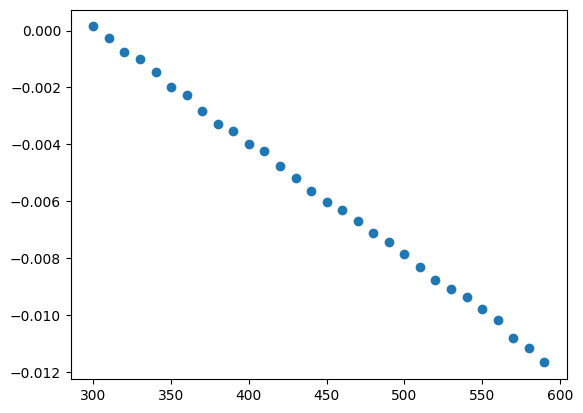

In [69]:
import numpy as np
from scipy import stats

# run anaylsis to see the deviation 
def leastAcceptableBias(MaxFlatChangePer = 0.001, start = 300, end = 600, step = 50, debug = False, all = False):
    output = {
        'bias': [],
        'df_mean': [],
        'df_std': [],
        'z_score': [],
        'p_value': [],
    }
    if all:
        f300 = makeCaliFlat_master(300)
    else:
        f300 = makeCaliFlatAll(300)
    for i in range (start, end, step):
        if all:
            f = makeCaliFlat_master(i)
        else:
            f = makeCaliFlatAll(i)
        df = (f - f300) / f300 * 100
        df_mean = np.mean(df)  
        df_std = np.std(df)
        z_score = (MaxFlatChangePer - df_mean) / df_std
        p_value = 2 * (1 - stats.norm.cdf(np.abs(z_score)))
        output['bias'].append(i)
        output['df_mean'].append(df_mean)
        output['df_std'].append(df_std)
        output['z_score'].append(z_score)
        output['p_value'].append(p_value)
        if p_value < 0.05:
            return output['bias']
    return output

output = leastAcceptableBias(MaxFlatChangePer = 0.001, start = 300, end = 600, step = 10, all = True)
plt.scatter(output['bias'], output['df_mean'])

        



In [ ]:
def linear_func(x, a, b):
    return a * x + b

In [47]:
def comparison(bias1, bias2, debug = False, hist = True):
    f1 = makeCaliFlat_master(bias1, debug = debug)
    f2 = makeCaliFlat_master(bias2, debug = debug)
    df = (f2 - f1) / f1 * 100 
    mean = np.mean(df)
    std = np.std(df)

    if debug:
        display_image(df, siglo = 0.5, sighi = 0.5, fignum = 7)
        plt.colorbar()
    if hist:
        fig, ax = plt.subplots()
        ax.hist(df.flatten(), bins = 20)
        # Show plot
        plt.show()  
    return mean, std

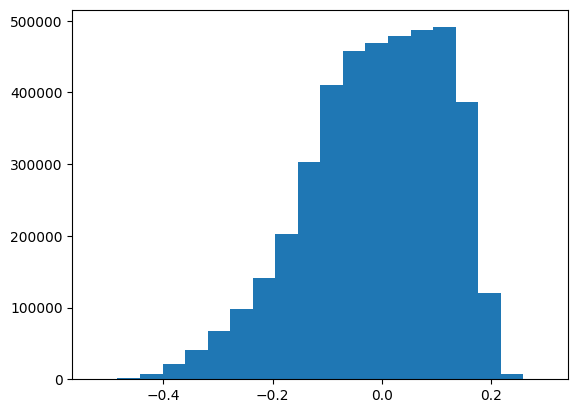

In [48]:
mean, std = comparison(300, 600)

In [ ]:
popt, pcov = curve_fit(linear_func, df['bias'], df['df_mean'])

In [ ]:
pred_flat_change = linear_func(np.linspace(300, 600, 10), *popt)

In [ ]:
plt.scatter(np.linspace(300, 600, 10), pred_flat_change)

-0.012133375865839329

0.12606448751914373

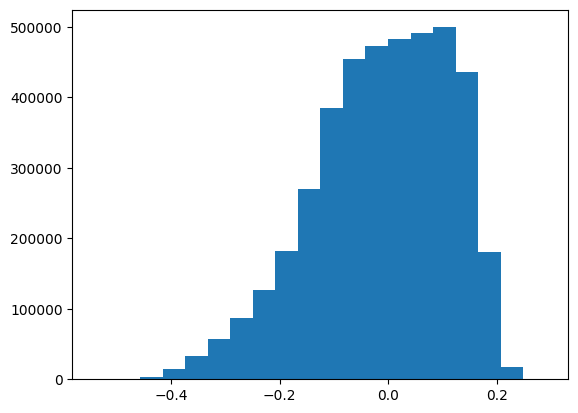

In [51]:
f300_2 = makeCaliFlat_master(300)
f600 = makeCaliFlat_master(600)
df = (f600 - f300_2) / f300_2 * 100 
mean = np.mean(df)
std = np.std(df)
display(mean, std)
# Creating histogram
fig, ax = plt.subplots()
ax.hist(df.flatten(), bins = 20)
 
# Show plot
plt.show()

-0.0003291218379111167

0.028308911939476437

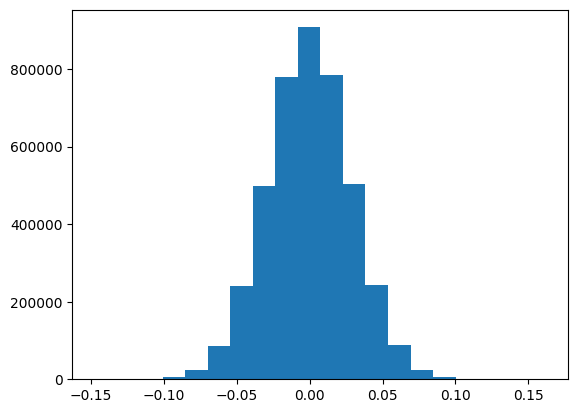

In [52]:
f300_2 = makeCaliFlat_master(300)
f600 = makeCaliFlat_master(300)
df = (f600 - f300_2) / f300_2 * 100 
mean = np.mean(df)
std = np.std(df)
display(mean, std)
# Creating histogram
fig, ax = plt.subplots()
ax.hist(df.flatten(), bins = 20)
 
# Show plot
plt.show()


In [ ]:
f300_2 = makeCaliFlatAll(300)
f600 = makeCaliFlatAll(300)
df = (f600 - f300_2) / f300_2 * 100 
mean = np.mean(df)
std = np.std(df)
display(mean, std)
# Creating histogram
fig, ax = plt.subplots()
ax.hist(df.flatten(), bins = 20)
 
# Show plot
plt.show()

In [ ]:
import numpy as np
from scipy import stats

# Define your data and parameters
sample_data = [98, 101, 105, 97, 102, 99, 100, 103, 98, 104]  # Sample data
sample_mean = np.mean(sample_data)  # Sample mean
sample_std = np.std(sample_data, ddof=1)  # Sample standard deviation
value_to_compare = 100.5  # Value to compare to
alpha = 0.05  # Significance level

# Perform a one-tailed t-test
t_statistic, p_value = stats.ttest_1samp(sample_data, value_to_compare)

# Calculate the degrees of freedom
degrees_of_freedom = len(sample_data) - 1

# Calculate the critical t-value for a one-tailed test (right-tail)
critical_t_value = stats.t.ppf(1 - alpha, df=degrees_of_freedom)

# Calculate the confidence interval
margin_of_error = critical_t_value * (sample_std / np.sqrt(len(sample_data)))
confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)

# Determine the result based on the p-value and alpha
if p_value < alpha:
    result = "Reject null hypothesis"
else:
    result = "Fail to reject null hypothesis"

# Print the results
print("T-Test Results:")
print(f"t-statistic: {t_statistic}")
print(f"P-Value: {p_value}")
print(f"Confidence Interval: {confidence_interval}")
print(f"Result: {result}")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
size = 2048
center = (size // 2, size // 2)
sigma = 5000

# Create a grid of x and y coordinates
x, y = np.meshgrid(np.arange(size), np.arange(size))

# Calculate the distances from the center using vectorized operations
distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
display(distance)

# Calculate the Gaussian values using vectorized operations
grid = np.exp(-distance**2 / (2 * sigma**2)) * (np.random.normal(300, 15) + np.random.poisson(f))

# # Normalize the values
# grid /= grid.max()

# Plot the result
plt.imshow(grid, cmap='viridis', origin='lower', extent=(0, size, 0, size))
plt.colorbar()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
size = 2048  # Size of the grid
center = (size // 2, size // 2)  # Center of the circle
sigma = 20  # Standard deviation for the Gaussian distribution

# Create an empty grid
grid = np.zeros((size, size))

# Fill the grid with Gaussian values
for x in range(size):
    for y in range(size):
        distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
        grid[x, y] = np.exp(-distance**2 / (2 * sigma**2))

# Normalize the values to make the center the highest value
grid /= grid.max()

# Plot the result
plt.imshow(grid, cmap='viridis', origin='lower', extent=(0, size, 0, size))
plt.colorbar()
plt.show()


In [ ]:
def func(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y

In [ ]:
flat_meas = makeCaliFlatAll(100)

In [ ]:
def propagation(bias_real_level = bias_real_level, bias_meas_array = bias_meas_array, tf_array = tf_array, debug = False, abs = False):
    # prop storage array
    percent_change_in_bias_array = []
    percent_change_in_flat_array = []
    tf_plot_array = []

    # making the real bias, dark, and flat
    bias_real = makeBias(bias_real_level)
    dark_real = makeDark(bias_real_level)
    flat_raw = makeRawGaussianFlat(bias_real_level)
    flat_real_dict = {}
    for tf in tf_array:
        flat_real = makeCaliFlat(bias_real, dark_real, flat_raw, tf)
        flat_real_dict[tf] = flat_real
        
    if debug:
        display(flat_real_dict[tf_array[1]])
        
    # prop 
    for b in bias_meas_array:
        # bias displacement
        deltab = b - bias_real_level
        # bias percent change mean
        percent_change_in_bias = (deltab * 100) / bias_real_level
        for tf in tf_array:
            # real calibrated flat in a 2d array 
            flat_real = flat_real_dict[tf]
            # measured flat in a 2d array
            flat_meas = makeCaliFlatAll(b)
            # flat displacement in a 2d 
            if abs:
                deltaf = np.abs(flat_meas - flat_real)
            else:
                deltaf = flat_meas - flat_real
            # flat percent change in a mean form 
            percent_change_in_flat = np.mean(deltaf / flat_real * 100)
            percent_change_in_bias_array.append(percent_change_in_bias)
            percent_change_in_flat_array.append(percent_change_in_flat)
            tf_plot_array.append(tf)
            
    if debug:
        ax = plt.axes(projection='3d')
        # Adding data to our axes, 's=40' is to increase point size by 40
        ax.scatter3D(percent_change_in_bias_array, tf_plot_array, percent_change_in_flat_array, s=1) 
        # Labelling your axes
        ax.set_xlabel('Percent change in Bias')
        ax.set_ylabel('Time Flat Exposure')
        ax.set_zlabel('Percent change in Flat')
        
    
    # Perform curve fitting
    popt, pcov = curve_fit(func, (percent_change_in_bias_array, tf_plot_array), percent_change_in_flat_array)
    
    if debug: 
            
        X, Y = np.meshgrid(percent_change_in_bias_array, tf_plot_array)
        pred_flat_change = func((X, Y), *popt)
        
        ax = plt.axes(projection='3d')
        # Adding data to our axes, 's=40' is to increase point size by 40
        ax.scatter3D(percent_change_in_bias_array, tf_plot_array, percent_change_in_flat_array, s=1) 
        ax.plot_surface(X, Y, pred_flat_change, color='red', alpha=0.5)
        # Labelling your axes
        ax.set_xlabel('Percent change in Bias')
        ax.set_ylabel('Time Flat Exposure')
        ax.set_zlabel('Percent change in Flat')
        
    return popt, pcov
            
    

In [ ]:
from tqdm.notebook import tqdm

def func(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y

def propagationVerion1(bias_real_level = bias_real_level, bias_meas_array = bias_meas_array, tf_array = tf_array, debug = False, abs = False):
    # prop storage array
    percent_change_in_bias_array = []
    percent_change_in_flat_array = []
    tf_plot_array = []

    # Replace this with the actual number of iterations or tasks you have
    total_iterations = len(bias_meas_array) * len(tf_array)
    # Create a tqdm object to display the progress bar
    progress_bar = tqdm(total=total_iterations, desc="Processing")
    
    for tf in tf_array:
        flat_real = makeCaliFlatAll(bias_real_level, tf=tf)
        for b in bias_meas_array:
            deltab = b - bias_real_level
            percent_change_in_bias = (deltab * 100) / bias_real_level
            # measured flat in a 2d array
            flat_meas = makeCaliFlatAll(b, tf=tf)
            # flat displacement in a 2d 
            if abs:
                deltaf = np.abs(flat_meas - flat_real)
            else:
                deltaf = flat_meas - flat_real
            # flat percent change in a mean form 
            percent_change_in_flat = np.mean(deltaf / flat_real * 100)
            percent_change_in_bias_array.append(percent_change_in_bias)
            percent_change_in_flat_array.append(percent_change_in_flat)
            tf_plot_array.append(tf)
            progress_bar.update(1)
            
    if debug:
        ax = plt.axes(projection='3d')
        # Adding data to our axes, 's=40' is to increase point size by 40
        ax.scatter3D(percent_change_in_bias_array, tf_plot_array, percent_change_in_flat_array, s=1) 
        # Labelling your axes
        ax.set_xlabel('Percent change in Bias')
        ax.set_ylabel('Time Flat Exposure')
        ax.set_zlabel('Percent change in Flat')
    
    progress_bar.close()
    print("Task completed.")
    # Perform curve fitting
    popt, pcov = curve_fit(func, (percent_change_in_bias_array, tf_plot_array), percent_change_in_flat_array)
    
    if debug: 
            
        X, Y = np.meshgrid(percent_change_in_bias_array, tf_plot_array)
        pred_flat_change = func((X, Y), *popt)
        
        ax = plt.axes(projection='3d')
        # Adding data to our axes, 's=40' is to increase point size by 40
        ax.scatter3D(percent_change_in_bias_array, tf_plot_array, percent_change_in_flat_array, s=1) 
        ax.plot_surface(X, Y, pred_flat_change, color='red', alpha=0.5)
        # Labelling your axes
        ax.set_xlabel('Percent change in Bias')
        ax.set_ylabel('Time Flat Exposure')
        ax.set_zlabel('Percent change in Flat')
        
    return popt, pcov
            
    

In [ ]:
popt, pcov = propagationVerion1(debug = True)